In [1]:
#import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imread, imshow, subplots, show

from sklearn.metrics import confusion_matrix, RocCurveDisplay, classification_report, accuracy_score, classification_report
#rom sklearn.metrics import RocCurveDisplay

In [2]:
# Load the subset from the file
data = np.load('Tomato_balanced.npz')
X_train_balanced = data['X_train_balanced']
y_train_balanced = data['y_train_balanced']

In [3]:
# Load the subset from the file
data = np.load('Tomato_test.npz')
X_test = data['X_test']
y_test = data['y_test']

In [4]:
# Load the subset from the file
data = np.load('Tomato_val.npz')
X_val = data['X_val']
y_val = data['y_val']

In [5]:
X_train_balanced.shape

(4252, 224, 224, 3)

In [6]:
X_val.shape

(902, 224, 224, 3)

In [7]:
X_test.shape

(461, 224, 224, 3)

In [8]:
img_shape = X_train_balanced.shape[1:]
img_shape

(224, 224, 3)

In [9]:
#Identify class distribution
unique_classes, class_counts = np.unique(y_train_balanced, return_counts=True)

dict(zip(unique_classes, class_counts))

{0: 450, 1: 450, 2: 632, 3: 716, 4: 654, 5: 450, 6: 450, 7: 450}

In [10]:
class_labels = ['Early_blight','Healthy','Late_blight','Leaf_Miner',
                 'Magnesium_Deficiency','Nitrogen_Deficiency','Pottassium_Deficiency','Spotted_Wilt_Virus']
len(class_labels)

8

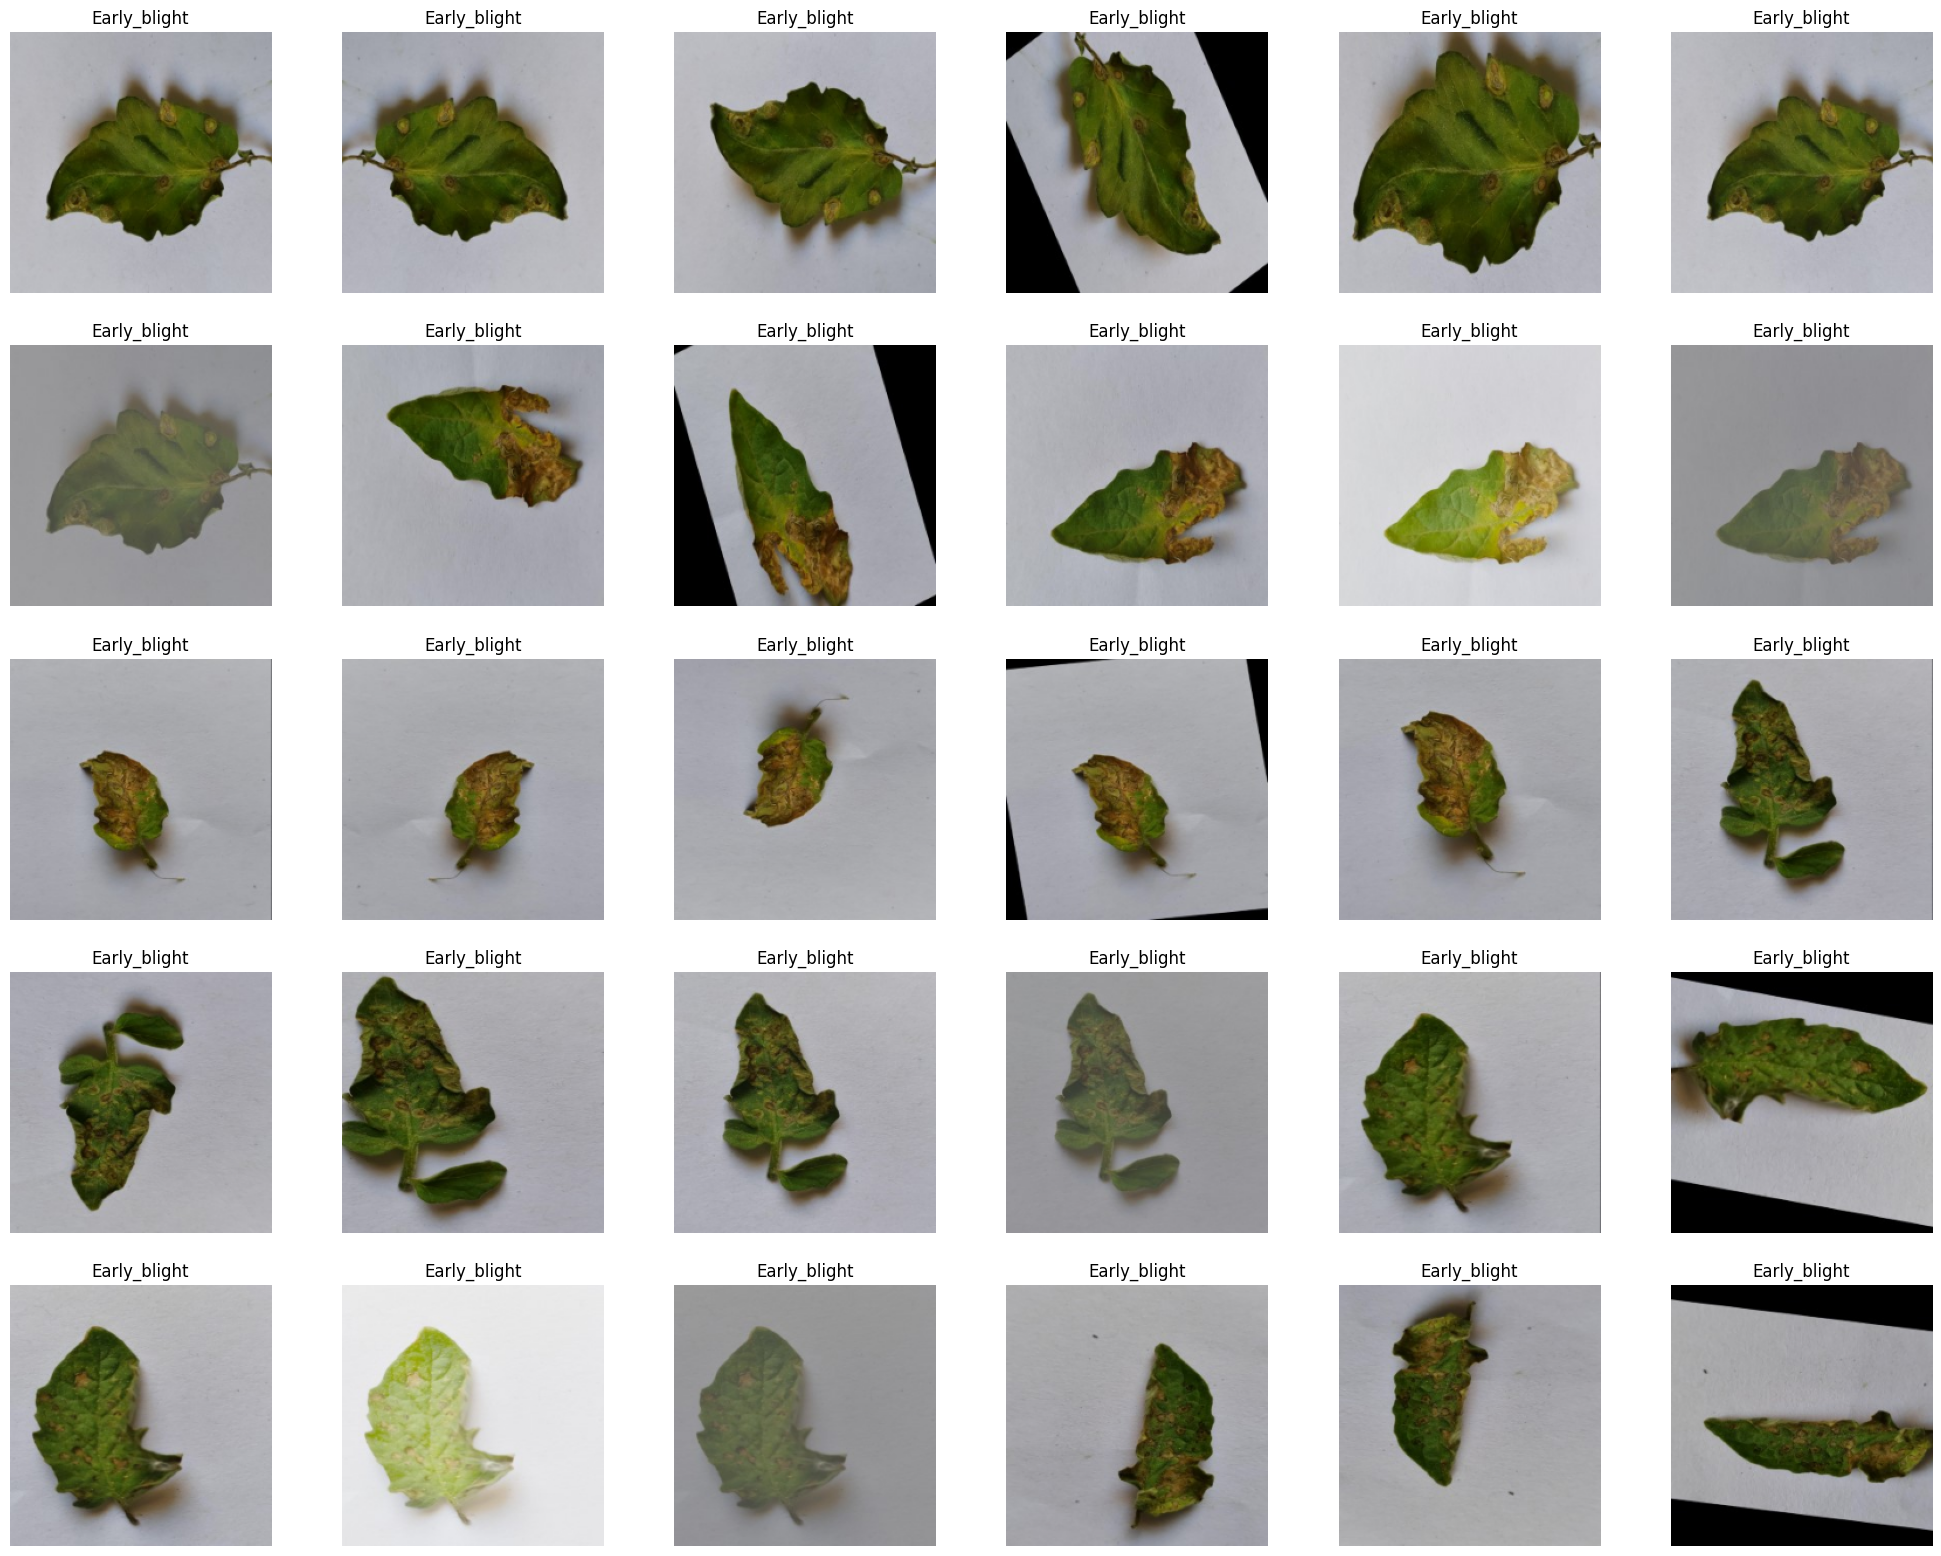

In [11]:
plt.figure(figsize=(25,40))
for i in range(30):
    plt.subplot(10,6,i+1)
    plt.imshow(X_train_balanced[i])
    plt.title(class_labels[y_train_balanced[i]])
    plt.axis("off")

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [13]:
base_model = tf.keras.applications.InceptionV3(input_shape=img_shape,
                                               include_top=False, 
                                               weights='imagenet')

In [14]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [15]:
base_model.trainable = True

In [16]:
n_classes = 8
InceptionV3 = tf.keras.Sequential([
  base_model,
  #data_augmentation,
  tf.keras.layers.GlobalAveragePooling2D(),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(n_classes, activation='softmax')
])

In [17]:
InceptionV3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 16392     
Total params: 21,819,176
Trainable params: 21,784,744
Non-trainable params: 34,432
_________________________________________________________________


In [18]:
InceptionV3.compile(optimizer='adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(
                          from_logits=False,
                          name='sparse_categorical_crossentropy'),
             metrics = ['accuracy'])

In [19]:
import time
start = time.time()

history = InceptionV3.fit(X_train_balanced, y_train_balanced, validation_data=(X_val, y_val), batch_size=16, epochs=50)

end = time.time()
total_time = end - start

Epoch 1/50
266/266 [==============================] - 50s 123ms/step - loss: 1.0481 - accuracy: 0.6493 - val_loss: 1.5878 - val_accuracy: 0.5011
Epoch 2/50
266/266 [==============================] - 33s 124ms/step - loss: 0.7275 - accuracy: 0.7554 - val_loss: 2.2848 - val_accuracy: 0.3437
Epoch 3/50
266/266 [==============================] - 33s 126ms/step - loss: 0.5787 - accuracy: 0.8062 - val_loss: 2.3550 - val_accuracy: 0.5754
Epoch 4/50
266/266 [==============================] - 33s 125ms/step - loss: 0.4696 - accuracy: 0.8337 - val_loss: 0.8675 - val_accuracy: 0.7173
Epoch 5/50
266/266 [==============================] - 34s 127ms/step - loss: 0.4290 - accuracy: 0.8561 - val_loss: 2.1159 - val_accuracy: 0.4900
Epoch 6/50
266/266 [==============================] - 33s 125ms/step - loss: 0.2907 - accuracy: 0.9038 - val_loss: 2.4933 - val_accuracy: 0.5532
Epoch 7/50
266/266 [==============================] - 33s 126ms/step - loss: 0.2913 - accuracy: 0.8991 - val_loss: 1.6219 - val_ac

In [20]:
print(f"Total time taken for fitting: {total_time:.2f} sec")

Total time taken for fitting: 1682.75 sec


In [21]:
InceptionV3.evaluate(X_test, y_test)

15/15 [==============================] - 3s 125ms/step - loss: 0.6443 - accuracy: 0.8590


[0.6443236470222473, 0.8590021729469299]

Text(0.5, 1.0, 'Training and Validation Accuracy')

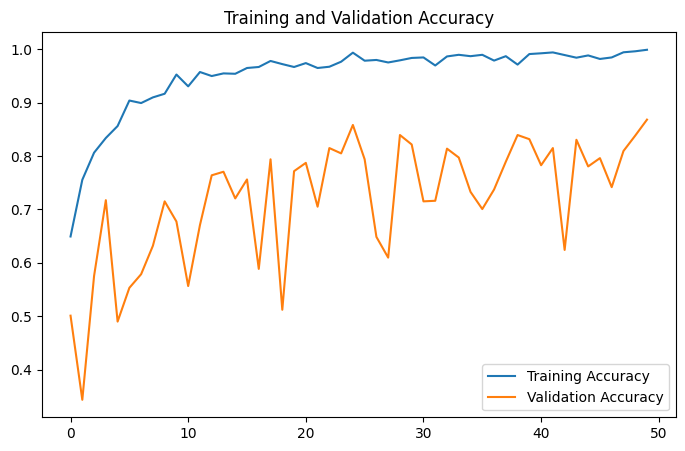

In [22]:
epochs =50

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(epochs)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

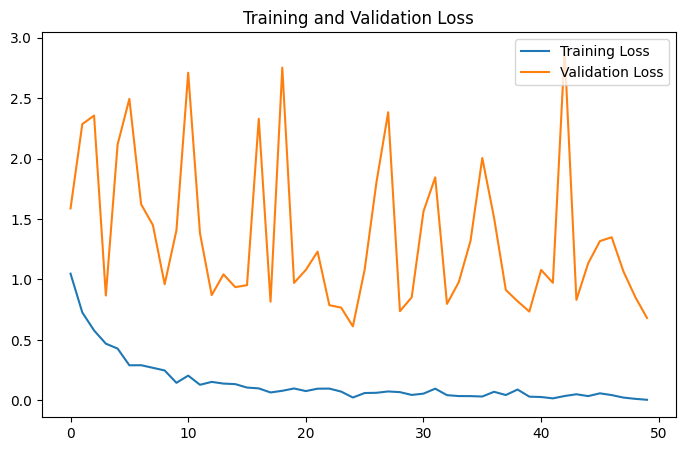

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
# For TensorFlow/Keras models
InceptionV3.save("InceptionV3_finetune.h5")
print("Model saved to InceptionV3_finetune.h5")


Model saved to InceptionV3_finetune.h5


In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

y_pred = InceptionV3.predict(X_test)

y_pred1 = np.array(list(map(lambda x: np.argmax(x), y_pred))) #pred_prob = np.argmax(y_pred, axis=1) ## 1-dimentional
    
report = classification_report(y_test, y_pred1)
    
print(report)

              precision    recall  f1-score   support

           0       0.82      0.66      0.73        50
           1       0.74      0.77      0.76        22
           2       0.85      0.89      0.87        92
           3       0.88      0.88      0.88       104
           4       0.97      0.95      0.96        95
           5       0.92      0.92      0.92        37
           6       0.89      1.00      0.94         8
           7       0.69      0.77      0.73        53

    accuracy                           0.86       461
   macro avg       0.85      0.85      0.85       461
weighted avg       0.86      0.86      0.86       461



In [28]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report, RocCurveDisplay, recall_score, f1_score
from sklearn.metrics import precision_score

accuracy = accuracy_score(y_test, y_pred1)
precision = precision_score(y_test, y_pred1, average='weighted')
recall = recall_score(y_test, y_pred1, average='weighted')
f1 = f1_score(y_test, y_pred1, average='weighted')
precision_per_class = precision_score(y_test, y_pred1, average=None)
f1_per_class = f1_score(y_test, y_pred1, average=None)

# Print metrics as percentages rounded to 2 decimal places
print(f"SVM Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

# Print precision and F1 score per class, rounded to 2 decimal places as percentages
print(f"Precision per Class: {[round(p * 100, 2) for p in precision_per_class]}%")
print(f"F1 Score per Class: {[round(f * 100, 2) for f in f1_per_class]}%")

SVM Test Accuracy: 85.90%
Precision: 86.13%
Recall: 85.90%
F1 Score: 85.87%
Precision per Class: [82.5, 73.91, 84.54, 88.35, 96.77, 91.89, 88.89, 69.49]%
F1 Score per Class: [73.33, 75.56, 86.77, 87.92, 95.74, 91.89, 94.12, 73.21]%


[[33  1  4  4  1  1  0  6]
 [ 0 17  0  4  0  0  0  1]
 [ 1  0 82  1  0  1  0  7]
 [ 4  5  0 91  1  0  0  3]
 [ 1  0  0  2 90  1  0  1]
 [ 0  0  1  0  1 34  1  0]
 [ 0  0  0  0  0  0  8  0]
 [ 1  0 10  1  0  0  0 41]]


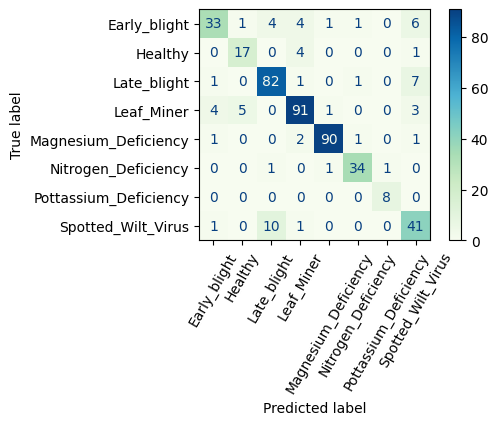

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred1)
print(cm)


display_cm = ConfusionMatrixDisplay(cm, display_labels=class_labels)
fig,ax = plt.subplots(figsize=(5,3))
display_cm.plot(cmap='GnBu', ax=ax, xticks_rotation=60)

In [30]:
from sklearn.metrics import roc_curve, auc
import sklearn

sklearn.metrics.roc_auc_score(y_test, y_pred, multi_class='ovr')

0.9838995186967745

In [31]:
from tensorflow.keras.utils import to_categorical
y_test_cat = tf.keras.utils.to_categorical(y_test)
y_test_cat

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

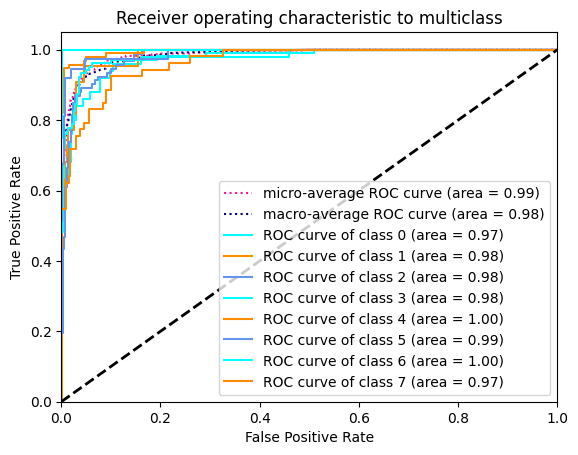

In [32]:
n_classes=8
 
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_cat.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

lw=2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
from itertools import cycle
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])



##### Plot all ROC curves ######


plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle="dotted",
    linewidth=1.5,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle="dotted",
    linewidth=1.5,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=1.5,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [33]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, y_pred1)

0.8306832564867552

In [34]:
from sklearn.metrics import log_loss
log_loss(y_test, y_pred)

0.6443236721002455

In [35]:
from tensorflow.keras.models import load_model

# Load the  model
loaded_InceptionV3 = load_model("InceptionV3_finetune.h5")
print("Model loaded from InceptionV3_finetune.h5")

Model loaded from InceptionV3_finetune.h5


In [36]:
loaded_InceptionV3.evaluate(X_test, y_test)

15/15 [==============================] - 2s 58ms/step - loss: 0.6443 - accuracy: 0.8590


[0.6443236470222473, 0.8590021729469299]


Image Index: 198


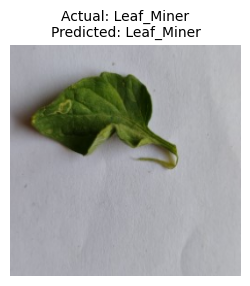


Image Index: 73


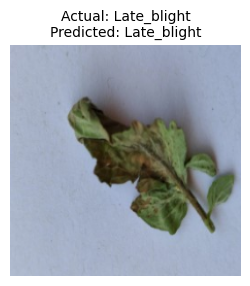


Image Index: 130


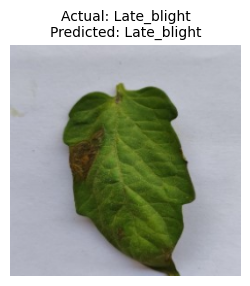


Image Index: 105


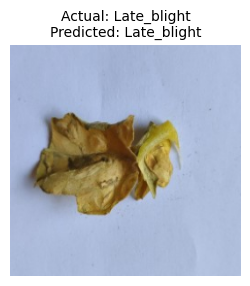


Image Index: 204


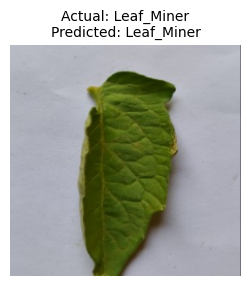


Image Index: 180


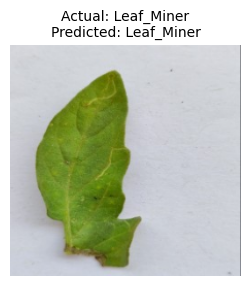


Image Index: 430


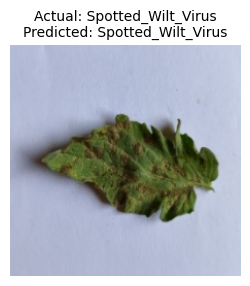


Image Index: 54


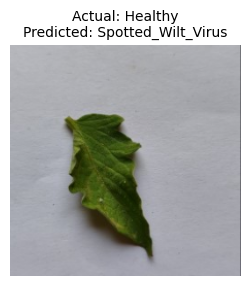


Image Index: 27


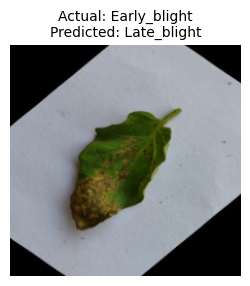


Image Index: 261


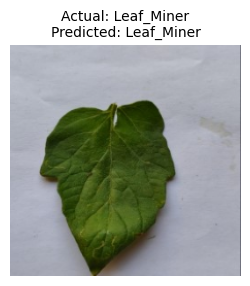


Image Index: 455


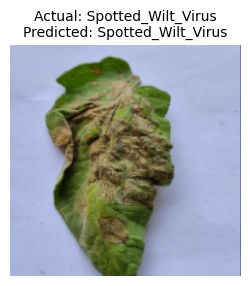


Image Index: 120


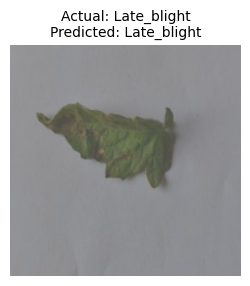


Image Index: 280


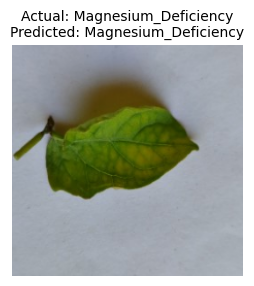


Image Index: 262


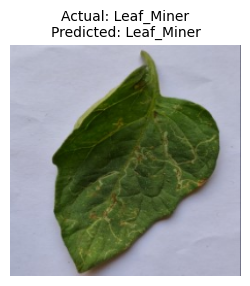


Image Index: 141


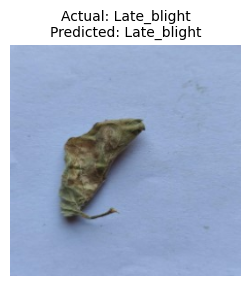


Image Index: 8


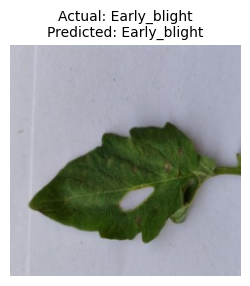


Image Index: 340


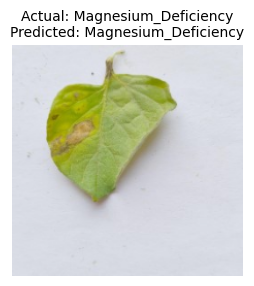


Image Index: 236


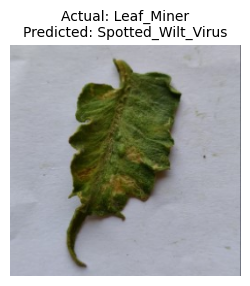


Image Index: 226


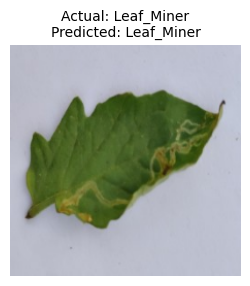


Image Index: 252


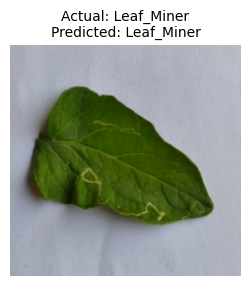

In [37]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Select 20 random indices from the test set
random_indices = random.sample(range(len(X_test)), 20)

class_labels = ['Early_blight','Healthy','Late_blight','Leaf_Miner',
                 'Magnesium_Deficiency','Nitrogen_Deficiency','Pottassium_Deficiency','Spotted_Wilt_Virus']

# Loop through the randomly selected indices
for index in random_indices:
    # Select the test image and its corresponding actual label
    test_image = X_test[index]
    actual_label_index = y_test[index]  # Assuming y_test contains the actual labels as indices

    # Add a batch dimension (required by the CNN model)
    test_image_batch = np.expand_dims(test_image, axis=0)  # Shape becomes (1, 224, 224, 3)

    # Predict the class probabilities for the image
    predictions = loaded_InceptionV3.predict(test_image_batch)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Get the actual and predicted class labels
    actual_label = class_labels[actual_label_index]
    predicted_label = class_labels[predicted_class_index]

    # Display the image with Matplotlib
    plt.figure(figsize=(3, 3))  # Set figure size

    # If the image is normalized, scale it back to the range [0, 255] for display
    if test_image.max() <= 1.0:
        display_image = test_image * 255  # Rescale to [0, 255]
    else:
        display_image = test_image  # If already in [0, 255], keep it as is

    # Display the image
    print()
    print(f"Image Index: {index}")
    plt.imshow(display_image.astype('uint8'))  # Convert to uint8 for correct display
    plt.axis('off')  # Turn off axis
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10)  # Add title
    plt.show()
